In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import cv2
import warnings
import random

# Suppress warnings and TensorFlow logs
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Configure matplotlib
%matplotlib inline

# Import necessary libraries
from keras.models import Sequential
from keras.layers import Conv2D, Dense, MaxPooling2D, Flatten, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.preprocessing import LabelEncoder
#from tensorflow.keras.utils import to_categorical

In [10]:
# Updated paths for local directory structure
train_dir = "./archive/train/"
val_dir = "./archive/validation/"
test_dir = "./archive/test/"


In [11]:
def import_dataset(directory):
    images = []
    labels = []
    
    for category in os.listdir(directory):
        for file in os.listdir(directory+category):
            image_path = os.path.join(directory,category,file)
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image,(224,224))
            images.append(image)
            labels.append(category)
    
    images = np.array(images,dtype='float32')
    return images, labels

In [12]:
train_images, train_labels = import_dataset(train_dir)
valid_images, valid_labels = import_dataset(val_dir)
test_images, test_labels = import_dataset(test_dir)

In [13]:
train_images.shape, len(train_labels)

((3540, 224, 224, 3), 3540)

<Axes: xlabel='count'>

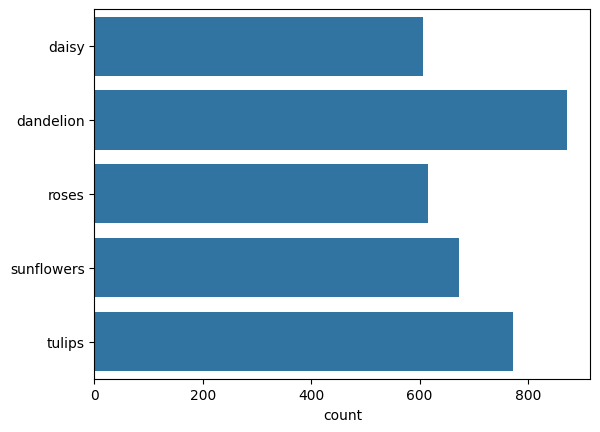

In [14]:
sns.countplot(train_labels)

<Axes: xlabel='count'>

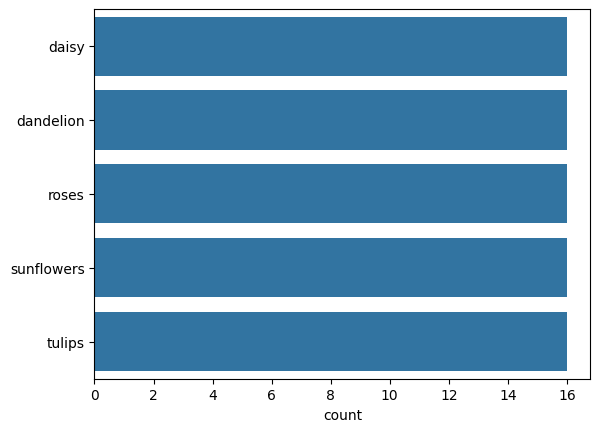

In [15]:
sns.countplot(valid_labels)

<Axes: xlabel='count'>

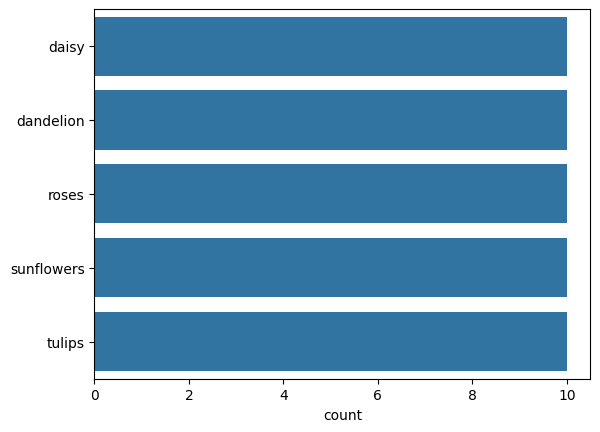

In [16]:
sns.countplot(test_labels)

In [17]:
def proportion(labels,dataset_type='train'):
    label_data = {'daisy': 0, 'roses': 1, 'dandelion': 2, 'sunflowers': 3, 'tulips': 4}
    plt.figure(figsize=(13,5))
    plt.title("Proportion of each Category in the {} dataset".format(dataset_type))
    plt.pie(x=pd.Series(labels).value_counts(), labels=list(label_data.keys()),  autopct='%.2f%%')
    plt.show()

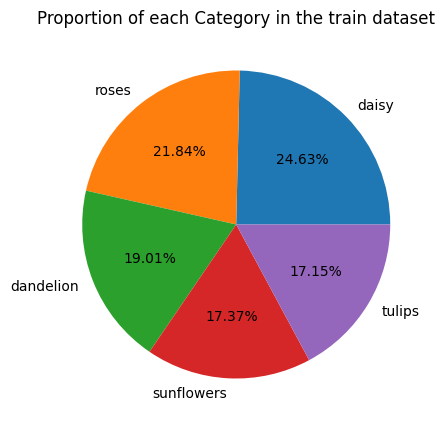

In [18]:
proportion(train_labels)

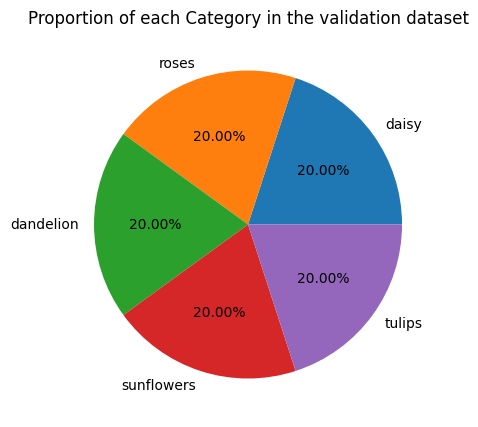

In [19]:
proportion(valid_labels,'validation')

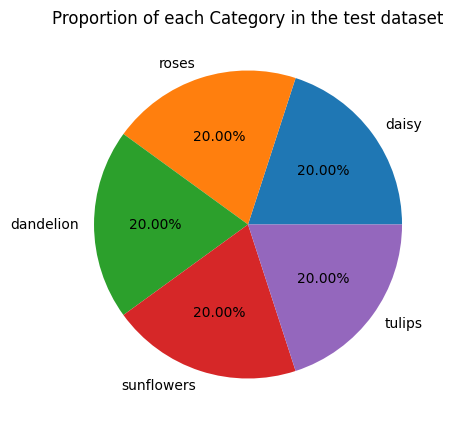

In [20]:
proportion(test_labels,'test')

In [21]:
train_images = train_images / 255.
valid_images = valid_images / 255.
test_images = test_images / 255.

In [22]:
encoder = LabelEncoder()
train_labels = encoder.fit_transform(train_labels)
train_labels = to_categorical(train_labels)
valid_labels = encoder.transform(valid_labels)
valid_labels = to_categorical(valid_labels)
test_labels = encoder.transform(test_labels)
test_labels = to_categorical(test_labels)

In [23]:
# Initializing a CNN layer
cnn = Sequential()

# 1st Convolutional Layer
cnn.add(Conv2D(filters=32,kernel_size=(3,3),activation='relu',input_shape=(224,224,3)))
cnn.add(MaxPooling2D(pool_size=2,strides=2))
cnn.add(BatchNormalization())

# 2nd Convolutional Layer
cnn.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu'))
cnn.add(MaxPooling2D(pool_size=2))
cnn.add(BatchNormalization())

# 3rd Convolutional Layer
cnn.add(Conv2D(filters=128,kernel_size=(3,3),activation='relu'))
cnn.add(MaxPooling2D(pool_size=2))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.25))

# 4th Convolutional Layer
cnn.add(Conv2D(filters=128,kernel_size=(3,3),activation='relu'))
cnn.add(MaxPooling2D(pool_size=2))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.3))

# Flatten
cnn.add(Flatten())

# Fully Connected Layer
cnn.add(Dense(units=128,activation='relu'))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.25))

# Output Layer
cnn.add(Dense(units=5,activation='softmax'))

In [24]:
cnn.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)


In [25]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 111, 111, 32)      128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                        

In [27]:
early_stopping = EarlyStopping(monitor='val_accuracy',patience=20,mode='max',verbose=1,restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',factor=0.1,patience=5,verbose=1,min_lr=0.001)
checkpoint_filepath = 'checkpoint/cnn_model.weights.h5'
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1,
    save_weights_only=True
)
r = cnn.fit(x=train_images,
            y=train_labels,
            epochs=30,
            batch_size=32,
            validation_data=(valid_images,valid_labels),
            callbacks=[early_stopping,reduce_lr,model_checkpoint])

Epoch 1/30


111/111 [==============================] - ETA: 0s - loss: 1.2890 - accuracy: 0.5395
Epoch 1: val_accuracy improved from -inf to 0.20000, saving model to checkpoint\cnn_model.weights.h5
111/111 [==============================] - 79s 665ms/step - loss: 1.2890 - accuracy: 0.5395 - val_loss: 3.6457 - val_accuracy: 0.2000 - lr: 0.0010
Epoch 2/30
111/111 [==============================] - ETA: 0s - loss: 0.9002 - accuracy: 0.6667
Epoch 2: val_accuracy did not improve from 0.20000
111/111 [==============================] - 73s 659ms/step - loss: 0.9002 - accuracy: 0.6667 - val_loss: 2.4927 - val_accuracy: 0.2000 - lr: 0.0010
Epoch 3/30
111/111 [==============================] - ETA: 0s - loss: 0.7783 - accuracy: 0.7102
Epoch 3: val_accuracy improved from 0.20000 to 0.30000, saving model to checkpoint\cnn_model.weights.h5
111/111 [==============================] - 72s 646ms/step - loss: 0.7783 - accuracy: 0.7102 - val_loss: 1.6524 - val_accuracy: 0.3000 - lr: 0.0010
Epoch 4/30
11

In [28]:
cnn.load_weights(checkpoint_filepath)

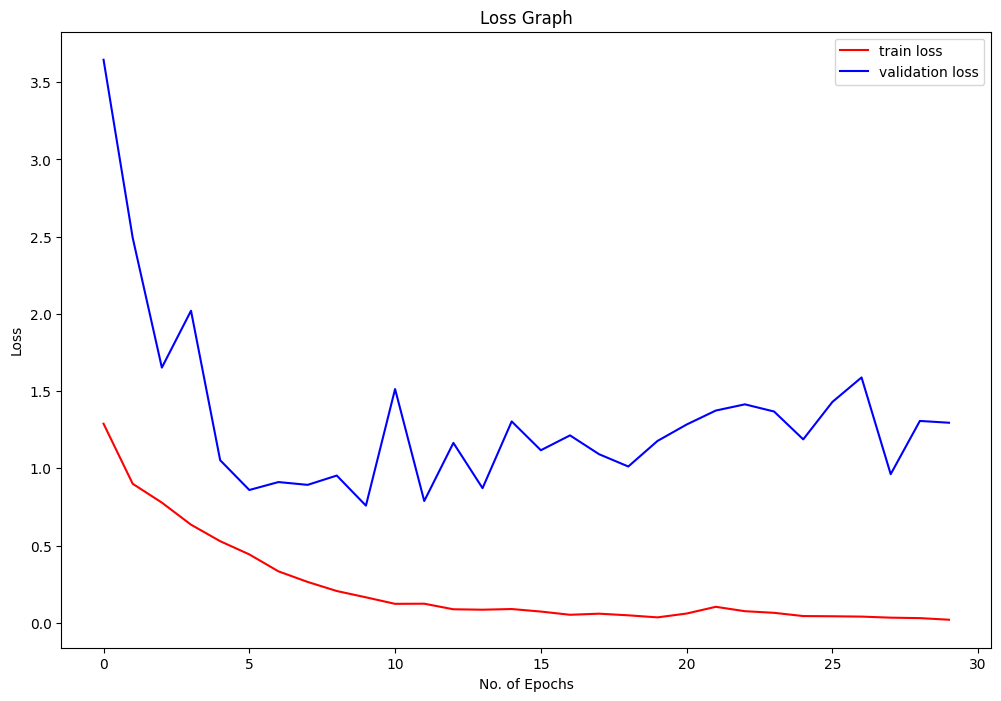

In [29]:
plt.figure(figsize=(12,8))
plt.plot(r.history['loss'],'r',label='train loss')
plt.plot(r.history['val_loss'],'b',label='validation loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend();

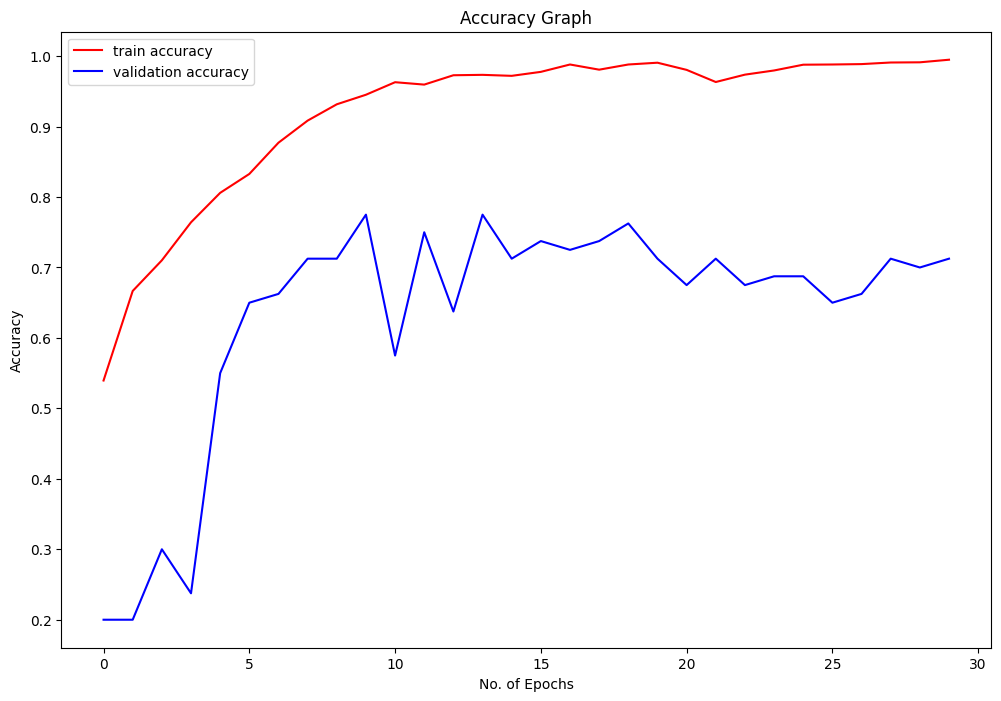

In [30]:
plt.figure(figsize=(12,8))
plt.plot(r.history['accuracy'],'r',label='train accuracy')
plt.plot(r.history['val_accuracy'],'b',label='validation accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend();

In [31]:
test_pred = cnn.predict(test_images) 

2/2 [==============================] - 1s 157ms/step


In [32]:
print("Accuracy Score:", str(int(np.sum(np.argmax(test_labels,axis=1) == np.argmax(test_pred,axis=1)) / len(test_labels) * 100)) + '%')

Accuracy Score: 70%


Original Label: dandelion
1/1 [==============================] - 0s 48ms/step
Predicted Label: dandelion


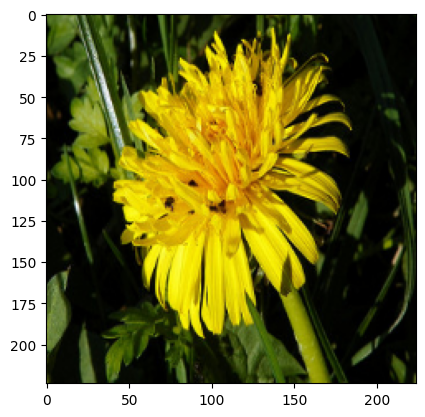

In [33]:
img_idx = random.randint(0,len(test_images))
print("Original Label:", encoder.inverse_transform([np.argmax(test_labels[img_idx])])[0])
pred = cnn.predict(test_images[img_idx].reshape(1,224,224,3))
predicted_label = encoder.inverse_transform([pred.argmax()])[0]
print("Predicted Label:", predicted_label)
plt.imshow(test_images[img_idx]);

Original Label: dandelion
1/1 [==============================] - 0s 45ms/step
Predicted Label: dandelion


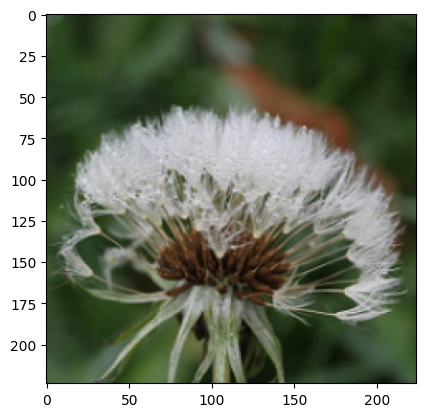

In [34]:
img_idx = 10
print("Original Label:", encoder.inverse_transform([np.argmax(test_labels[img_idx])])[0])
pred = cnn.predict(test_images[img_idx].reshape(1,224,224,3))
predicted_label = encoder.inverse_transform([pred.argmax()])[0]
print("Predicted Label:", predicted_label)
plt.imshow(test_images[img_idx]);